# SPICE Tool for Calculating Seasons on Giant Planets

L.N. Fletcher (2021)

### Date
The date must be in UTC and ISO format (yyyy-mm-dd hh:mm:ss or yyyy-mm-ddThh:mm:ss). 

### Kernel path
This is the path to the generic_kernels folder provided by NAIF (see description [here](https://naif.jpl.nasa.gov/naif/data_generic.html)). You can dowload this data to any folder by running the following command in a UNIX shell:

```bash
wget -m -nH --cut-dirs=2 -nv ftp://naif.jpl.nasa.gov/pub/naif/generic_kernels/
```
This will create the `generic_kernels` folder in the current directory, which is the location that `kernel_path` should point to.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime
import spiceypy as spice
import glob, re, os
import time

print(spice.tkvrsn('TOOLKIT'))
kernel_path = '/Users/lnf2/Data/generic_kernels/'

CSPICE_N0066


In [2]:
def find_spice_kernels(kernel_path):
    pcks  = sorted(glob.glob(kernel_path+"pck/*.tpc"))
    spks1 = sorted(glob.glob(kernel_path+"spk/planets/*.bsp"))
    #spks1 = sorted(glob.glob(kernel_path+"spk/de*.bsp"))
    spks2 = sorted(glob.glob(kernel_path+"spk/satellites/*.bsp"))
    fks   = sorted(glob.glob(kernel_path+"fk/planets/*.tf"))
    lsks  = sorted(glob.glob(kernel_path+"lsk/naif*.tls"))


    kernels = [pcks[-1], spks1[-1], *spks2, lsks[-1]]
    #kernels = [*pcks, *spks1, *spks2, *lsks, *fks]
    
    for kernel in kernels:
        print(kernel)
        spice.furnsh(kernel)

find_spice_kernels(kernel_path)

/Users/lnf2/Data/generic_kernels/pck/pck00010.tpc
/Users/lnf2/Data/generic_kernels/spk/planets/de441_part-2.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/jup310.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/jup343.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/mar097.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/nep086.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/nep095.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/plu055.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat319.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat368.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat393-rocks_pan.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat393.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat393_daphnis.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat427.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat428.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/ura111.bsp
/Users/lnf2/Data/generic_kernels/spk/satelli

In [5]:
help(spice.str2et)
help(spice.et2utc)
help(spice.lspcn)
help(spice.et2datetime)
help(spice.spkpos)
help(spice.subslr)

Help on function str2et in module spiceypy.spiceypy:

str2et(time: Union[str, Iterable[str]]) -> Union[float, numpy.ndarray]
    Convert a string representing an epoch to a double precision
    value representing the number of TDB seconds past the J2000
    epoch corresponding to the input epoch.
    
    https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/str2et_c.html
    
    :param time: A string representing an epoch.
    :return: The equivalent value in seconds past J2000, TDB.

Help on function et2utc in module spiceypy.spiceypy:

et2utc(et: Union[float, Iterable[float]], format_str: str, prec: int, lenout: int = 256) -> Union[numpy.ndarray, str]
    Convert an input time from ephemeris seconds past J2000
    to Calendar, Day-of-Year, or Julian Date format, UTC.
    
    https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/et2utc_c.html
    
    :param et: Input epoch, given in ephemeris seconds past J2000.
    :param format_str: Format of output epoch.
    :param prec:

###### 

In [3]:
utc = ['Oct 1, 2021']
et = spice.str2et(utc)
planets=['JUPITER','SATURN','URANUS','NEPTUNE']
abcorr='NONE'
rad2deg=180./np.pi

for planet in planets:
#     Compute L_s, the planetocentric longitude of the sun, as seen from a specified body.
    Ls=rad2deg*spice.lspcn(planet,et,abcorr)
    
    if Ls<90: 
        txt="(N. Spring)"
    if (Ls>=90) & (Ls<180): 
        txt="(N. Summer)"
    if (Ls>=180) & (Ls<270): 
        txt="(N. Autumn)"
    if (Ls>=270) & (Ls<360): 
        txt="(N. Winter)"
        
#     Return the position of a target body relative to an observing body, optionally corrected 
#         for light time (planetary aberration) and stellar aberration.
    [pos, ltime] = spice.spkpos( 'SUN', et, 'J2000','NONE', planet)
    dist = spice.vnorm( pos )
    dist_sun = spice.convrt( dist, 'KM', 'AU' )
    [pos, ltime] = spice.spkpos( 'EARTH', et, 'J2000','NONE', planet)
    dist = spice.vnorm( pos )
    dist_earth = spice.convrt( dist, 'KM', 'AU' )
    print('{:8s}'.format(planet),utc,' (L_s): {:8.2f}'.format(Ls),txt,' Sun (AU): {:6.2f}'.format(dist_sun),' Earth (AU): {:6.2f}'.format(dist_earth))
    
    
#     Look up the target body's radii. We'll use these to
#            convert Cartesian to planetographic coordinates. Use
#            the radii to compute the flattening coefficient of
#            the reference ellipsoid.
    id=spice.bods2c(planet)
    dim=3
    radii=spice.bodvar(id,'RADII',dim)
    re = radii[0]
    rp = radii[2]

    f  = ( re - rp ) / re
    
#     Compute the sub-solar point using light time and stellar
#            aberration corrections. Use the "target surface intercept"
#            definition of the sub-solar point on the first loop
#            iteration, and use the "near point" definition on the
#            second.
    method="Intercept/ellipsoid"
    if planet=="JUPITER":
        bodyref="IAU_JUPITER"
    if planet=="SATURN":
        bodyref="IAU_SATURN"
    if planet=="URANUS":
        bodyref="IAU_URANUS"
    if planet=="NEPTUNE":
        bodyref="IAU_NEPTUNE"
        
        
    spoint, trgrpc, srfvec = spice.subslr( method,
                         planet,  et,     bodyref, abcorr,"earth")
    
#     Convert the sub-observer point's rectangular coordinates
#               to planetographic longitude, latitude and altitude.
#               Convert radians to degrees.
    spglon, spglat, spgalt = spice.recpgr ( planet,  spoint,  re,     f)
    spglon=spglon*rad2deg
    spglat=spglat*rad2deg
    
#     Convert the sub-solar point's rectangular coordinates to
#               planetocentric radius, longitude, and latitude. Convert
#               radians to degrees.
    spcrad, spclon, spclat = spice.reclat(spoint)
    spclon=spclon*rad2deg
    spclat=spclat*rad2deg
    
    print("Sub-Solar:",'Centric Lat: {:6.3f}'.format(spclat),'; Graphic Lat: {:6.3f}'.format(spglat),
          '; Centric Lon: {:6.3f}'.format(spclon),'; Graphic Lon: {:6.3f}'.format(spglon))
    print(" ")
    
    

utc = ['Jan 1, 1970', 'Jan 1, 2051']
# get et values one and two, we could vectorize str2et
etOne = spice.str2et(utc[0])
etTwo = spice.str2et(utc[1])
print("ET: {}".format(etOne))

#ndays=(etTwo-etOne)/(24.*60.*60.)
#print(ndays)
#step=int((ndays/10))
#print(step)
#times = [x*(etTwo-etOne)/step + etOne for x in range(step)]

deltat=15.*24.*60.*60.
times=np.arange(etOne,etTwo,deltat)
step=len(times)

utc=spice.et2datetime(times)
ut=spice.et2utc(times,'D',1)
jd=spice.et2utc(times,'J',1)

#pltdates = [datetime.datetime.strptime(d).date() for d in utc]


print(utc[0])
Lsjup=np.empty(shape=step)
Lssat=np.empty(shape=step)
Lsura=np.empty(shape=step)
Lsnep=np.empty(shape=step)
sunjup=np.empty(shape=step)
sunsat=np.empty(shape=step)
sunura=np.empty(shape=step)
sunnep=np.empty(shape=step)
earthjup=np.empty(shape=step)
earthsat=np.empty(shape=step)
earthura=np.empty(shape=step)
earthnep=np.empty(shape=step)
sublat_jup=np.empty(shape=step)
sublat_sat=np.empty(shape=step)
sublat_ura=np.empty(shape=step)
sublat_nep=np.empty(shape=step)


date=np.empty(shape=step)

planets=['JUPITER','SATURN','URANUS','NEPTUNE']

for i in range(step):
    et=times[i]
    for planet in planets:
        
#     Compute L_s, the planetocentric longitude of the sun, as seen from a specified body.
        Ls=rad2deg*spice.lspcn(planet,et,abcorr)

#     Return the position of a target body relative to an observing body, optionally corrected 
#         for light time (planetary aberration) and stellar aberration.    
        [pos, ltime] = spice.spkpos( 'SUN', et, 'J2000','NONE', planet)
        dist = spice.vnorm( pos )
        dist_sun = spice.convrt( dist, 'KM', 'AU' )
        [pos, ltime] = spice.spkpos( 'EARTH', et, 'J2000','NONE', planet)
        dist = spice.vnorm( pos )
        dist_earth = spice.convrt( dist, 'KM', 'AU' )

        
        
#     Look up the target body's radii. We'll use these to
#            convert Cartesian to planetographic coordinates. Use
#            the radii to compute the flattening coefficient of
#            the reference ellipsoid.
        id=spice.bods2c(planet)
        dim=3
        radii=spice.bodvar(id,'RADII',dim)
        re = radii[0]
        rp = radii[2]
        f  = ( re - rp ) / re
        
        
#     Compute the sub-solar point using light time and stellar
#            aberration corrections. Use the "target surface intercept"
#            definition of the sub-solar point on the first loop
#            iteration, and use the "near point" definition on the
#            second.
        method="Intercept/ellipsoid"
        if planet=="JUPITER":
            bodyref="IAU_JUPITER"
        if planet=="SATURN":
            bodyref="IAU_SATURN"
        if planet=="URANUS":
            bodyref="IAU_URANUS"
        if planet=="NEPTUNE":
            bodyref="IAU_NEPTUNE"
        
        
        spoint, trgrpc, srfvec = spice.subslr( method,
                             planet,  et,     bodyref, abcorr,"earth")
    
#     Convert the sub-observer point's rectangular coordinates
#               to planetographic longitude, latitude and altitude.
#               Convert radians to degrees.
        spglon, spglat, spgalt = spice.recpgr ( planet,  spoint,  re,     f)
        spglon=spglon*rad2deg
        spglat=spglat*rad2deg
    
#     Convert the sub-solar point's rectangular coordinates to
#               planetocentric radius, longitude, and latitude. Convert
#               radians to degrees.
        spcrad, spclon, spclat = spice.reclat(spoint)
        spclon=spclon*rad2deg
        spclat=spclat*rad2deg

        

        if planet=="JUPITER":
            Lsjup[i]=Ls
            sunjup[i]=dist_sun
            earthjup[i]=dist_earth
            sublat_jup[i]=spglat
        if planet=="SATURN":
            Lssat[i]=Ls
            sunsat[i]=dist_sun
            earthsat[i]=dist_earth
            sublat_sat[i]=spglat
        if planet=="URANUS":
            Lsura[i]=Ls
            sunura[i]=dist_sun
            earthura[i]=dist_earth
            sublat_ura[i]=spglat
        if planet=="NEPTUNE":
            Lsnep[i]=Ls
            sunnep[i]=dist_sun
            earthnep[i]=dist_earth
            sublat_nep[i]=spglat
        
    
    
#    date[i]=datetime(utc[i])
   # print(Ls)
    
print(jd[0])

out=[utc,Lsjup,Lssat,Lsura,Lsnep,sunjup,sunsat,sunura,sunnep,sublat_jup,sublat_sat,sublat_ura,sublat_nep]
out=np.transpose(out)
np.savetxt("seasons.csv", out, delimiter=",",fmt=['%s' , '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f', '%f'],
           header='UTC, Ls-J, Ls-S, Ls-U, Ls-N, Dist-J (AU), Dist-S (AU), Dist-U (AU), Dist-N (AU), PGLat-J, PGLat-S, PGLat-U, PGLat-N',
           )


JUPITER  ['Oct 1, 2021']  (L_s):    13.45 (N. Spring)  Sun (AU):   5.01  Earth (AU):   4.26
Sub-Solar: Centric Lat:  0.725 ; Graphic Lat:  0.829 ; Centric Lon:  4.044 ; Graphic Lon: 355.956
 
SATURN   ['Oct 1, 2021']  (L_s):   138.14 (N. Summer)  Sun (AU):   9.94  Earth (AU):   9.42
Sub-Solar: Centric Lat: 17.466 ; Graphic Lat: 21.142 ; Centric Lon: -175.022 ; Graphic Lon: 175.022
 
URANUS   ['Oct 1, 2021']  (L_s):    54.55 (N. Spring)  Sun (AU):  19.74  Earth (AU):  18.92
Sub-Solar: Centric Lat: 53.815 ; Graphic Lat: 55.072 ; Centric Lon: 66.703 ; Graphic Lon: 66.703
 
NEPTUNE  ['Oct 1, 2021']  (L_s):   305.90 (N. Winter)  Sun (AU):  29.92  Earth (AU):  28.96
Sub-Solar: Centric Lat: -22.621 ; Graphic Lat: -23.331 ; Centric Lon: -64.717 ; Graphic Lon: 64.717
 
ET: -946727958.8160644
1970-01-01 00:00:00+00:00
JD 2440587.5


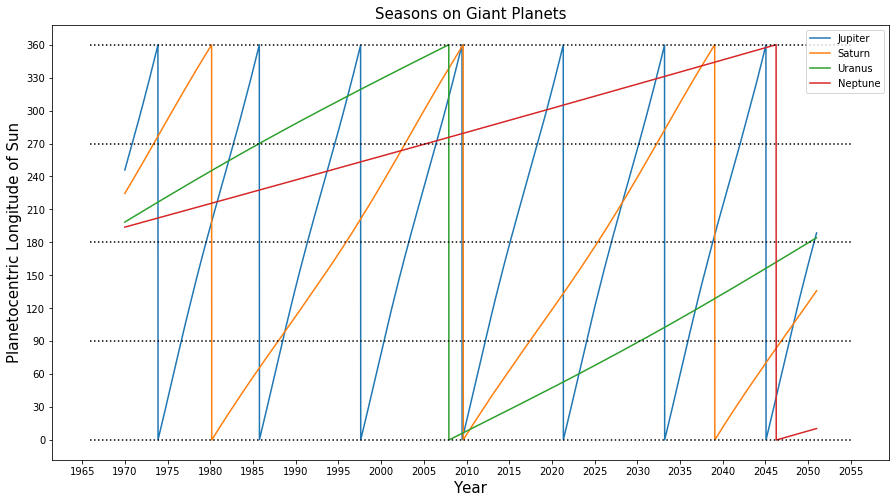

In [239]:
years = mdates.YearLocator(5)   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')


fig, ax = plt.subplots(figsize=(15,8))
ax.plot_date(utc,Lsjup,label="Jupiter",ls='solid',marker="None")
ax.plot_date(utc,Lssat,label="Saturn",ls='solid',marker="None")
ax.plot_date(utc,Lsura,label="Uranus",ls='solid',marker="None")
ax.plot_date(utc,Lsnep,label="Neptune",ls='solid',marker="None")

ax.set_xlabel("Year",size=15)
ax.set_ylabel("Planetocentric Longitude of Sun",size=15)
ax.set_title("Seasons on Giant Planets",size=15)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
#ax.xaxis.set_minor_locator(months)
start, end = ax.get_ylim()
stepsize=30
ax.yaxis.set_ticks(np.arange(0,361, stepsize))

start, end = ax.get_xlim()
ax.plot([start,end],[0,0],linestyle='dotted',color='black')
ax.plot([start,end],[90,90],linestyle='dotted',color='black')
ax.plot([start,end],[180,180],linestyle='dotted',color='black')
ax.plot([start,end],[270,270],linestyle='dotted',color='black')
ax.plot([start,end],[360,360],linestyle='dotted',color='black')


ax.legend()
plt.show()


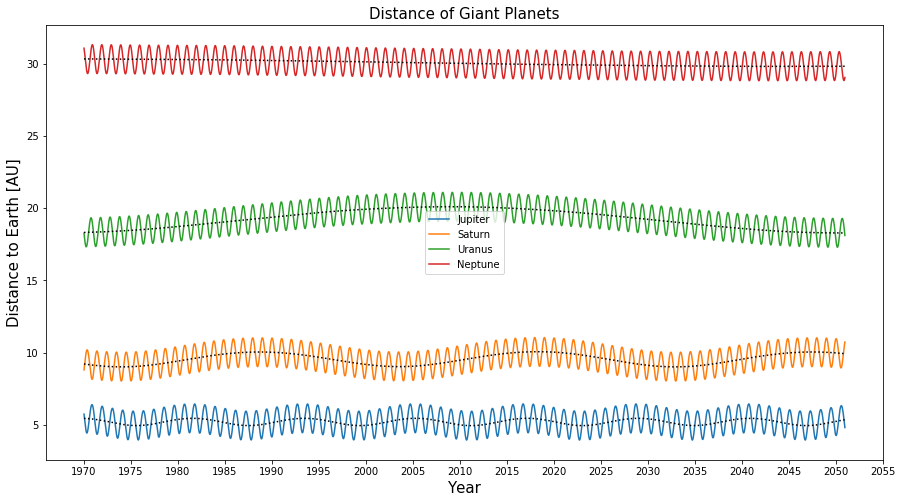

In [240]:
years = mdates.YearLocator(5)   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')


fig, ax = plt.subplots(figsize=(15,8))
ax.plot_date(utc,earthjup,label="Jupiter",ls='solid',marker="None")
ax.plot_date(utc,earthsat,label="Saturn",ls='solid',marker="None")
ax.plot_date(utc,earthura,label="Uranus",ls='solid',marker="None")
ax.plot_date(utc,earthnep,label="Neptune",ls='solid',marker="None")

ax.plot_date(utc,sunjup,ls='dotted',marker="None",color="black")
ax.plot_date(utc,sunsat,ls='dotted',marker="None",color="black")
ax.plot_date(utc,sunura,ls='dotted',marker="None",color="black")
ax.plot_date(utc,sunnep,ls='dotted',marker="None",color="black")

ax.set_xlabel("Year",size=15)
ax.set_ylabel("Distance to Earth [AU]",size=15)
ax.set_title("Distance of Giant Planets",size=15)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
#ax.xaxis.set_minor_locator(months)
start, end = ax.get_ylim()

stepsize=30
#ax.yaxis.set_ticks(np.arange(0,361, stepsize))

# start, end = ax.get_xlim()
# ax.plot([start,end],[0,0],linestyle='dotted',color='black')
# ax.plot([start,end],[90,90],linestyle='dotted',color='black')
# ax.plot([start,end],[180,180],linestyle='dotted',color='black')
# ax.plot([start,end],[270,270],linestyle='dotted',color='black')
# ax.plot([start,end],[360,360],linestyle='dotted',color='black')


ax.legend()
plt.show()


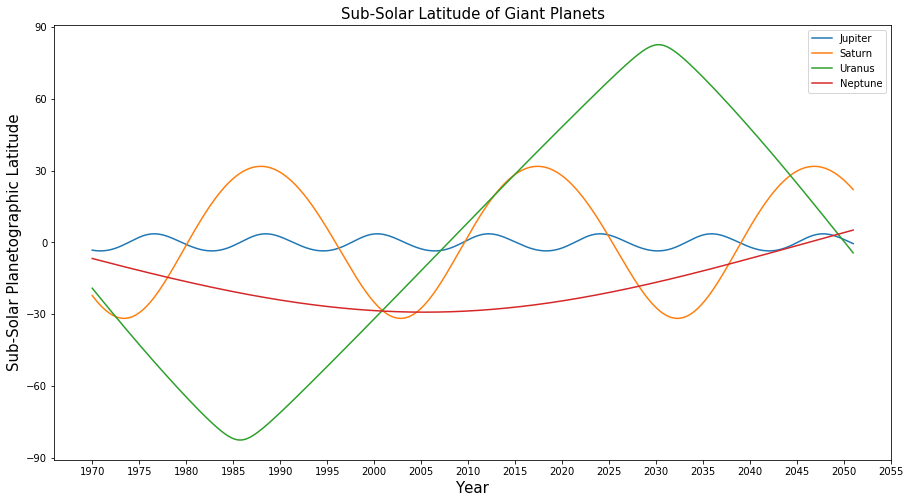

In [35]:
years = mdates.YearLocator(5)   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')


fig, ax = plt.subplots(figsize=(15,8))
ax.plot_date(utc,sublat_jup,label="Jupiter",ls='solid',marker="None")
ax.plot_date(utc,sublat_sat,label="Saturn",ls='solid',marker="None")
ax.plot_date(utc,sublat_ura,label="Uranus",ls='solid',marker="None")
ax.plot_date(utc,sublat_nep,label="Neptune",ls='solid',marker="None")


ax.set_xlabel("Year",size=15)
ax.set_ylabel("Sub-Solar Planetographic Latitude",size=15)
ax.set_title("Sub-Solar Latitude of Giant Planets",size=15)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
#ax.xaxis.set_minor_locator(months)
start, end = ax.get_ylim()

stepsize=30
ax.yaxis.set_ticks(np.arange(-90,91, stepsize))

# start, end = ax.get_xlim()
# ax.plot([start,end],[0,0],linestyle='dotted',color='black')
# ax.plot([start,end],[90,90],linestyle='dotted',color='black')
# ax.plot([start,end],[180,180],linestyle='dotted',color='black')
# ax.plot([start,end],[270,270],linestyle='dotted',color='black')
# ax.plot([start,end],[360,360],linestyle='dotted',color='black')


ax.legend()
plt.show()
